In [1]:
# Author: Roi Yehoshua <roiyeho@gmail.com>
# License: MIT
# May 2024

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 1. Loading the Data Set

In [3]:
from sklearn.datasets import fetch_20newsgroups

train_set = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
test_set = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

In [4]:
X_train, y_train = train_set.data, train_set.target
X_test, y_test = test_set.data, test_set.target

### 2. Data Exploration

In [5]:
print('Number of training documents:', len(X_train))
print('Number of test documents:', len(X_test))

Number of training documents: 11314
Number of test documents: 7532


In [6]:
categories = train_set.target_names
print(categories)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [7]:
print(X_train[0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [8]:
print('Document label:', categories[y_train[0]])

Document label: rec.autos


### 3. Text Preprocessing and Vectorization

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)

In [10]:
print(X_train_vec.shape)

(11314, 101631)


In [11]:
vocab = vectorizer.get_feature_names_out()
print(vocab[:10])

['00' '000' '0000' '00000' '000000' '00000000' '0000000004' '00000000b'
 '00000001' '00000001b']


In [12]:
print(X_train_vec.nnz / X_train_vec.shape[0])

97.54525366802191


In [13]:
import pandas as pd

df = pd.DataFrame(X_train_vec[:5].toarray(), columns=vocab)
df

,00,000,0000,00000,000000,00000000,0000000004,00000000b,00000001,00000001b,...,zznkzz,zznp,zzrk,zzy_3w,zzz,zzzoh,zzzzzz,zzzzzzt,³ation,ýé
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 4. Building the Model

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

model = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english')),
    ('clf', MultinomialNB(alpha=0.01))
])

model.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(stop_words='english')),
                ('clf', MultinomialNB(alpha=0.01))])

### 5. Evaluating the model

In [15]:
from sklearn.metrics import f1_score

accuracy_train = model.score(X_train, y_train)
y_train_pred = model.predict(X_train)
f1_train = f1_score(y_train, y_train_pred, average='macro')

print(f'Accuracy (train): {accuracy_train:.4f}')
print(f'F1 score (train): {f1_train:.4f}')

Accuracy (train): 0.9595
F1 score (train): 0.9622


In [16]:
accuracy_test = model.score(X_test, y_test)
y_test_pred = model.predict(X_test)
f1_test = f1_score(y_test, y_test_pred, average='macro')

print(f'Accuracy (test): {accuracy_test:.4f}')
print(f'F1 score (test): {f1_test:.4f}')

Accuracy (test): 0.7010
F1 score (test): 0.6844


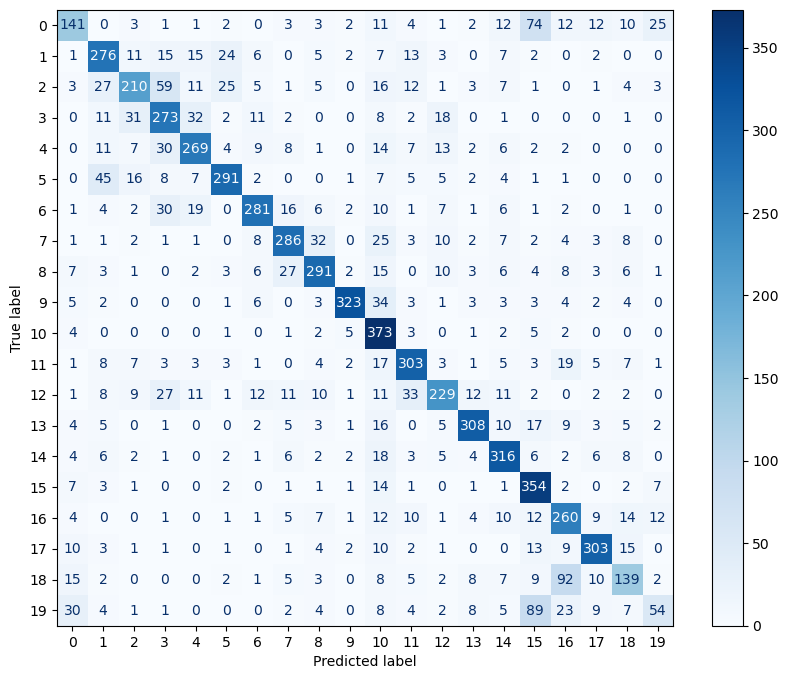

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_mat = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues')

plt.savefig('figures/multinomial_nb_confusion_matrix.pdf', bbox_inches='tight')

### 6. Benchmarking

In [18]:
import time
from sklearn.pipeline import make_pipeline

def evaluate_classifiers(classifiers, names, X_train, y_train, X_test, y_test, verbose=True):
    # Initialize a list to store evaluation results for each classifier
    evaluations = []

    # Iterate over each classifier and its corresponding name
    for clf, name in zip(classifiers, names):
        # Start timing the training process
        start_time = time.time()
        
        # Define a pipline with the vectorizer and the given classifier
        model = make_pipeline(TfidfVectorizer(stop_words='english'), clf)
        model.fit(X_train, y_train)
        
        # Calculate the elapsed time during training
        training_time = time.time() - start_time
        
        # Compute accuracy of the classifier on the test set
        accuracy = model.score(X_test, y_test)
        
        # Store the results in a dictionary
        evaluation = {
            'classifier': name,
            'training_time': training_time,
            'accuracy': accuracy
        }        
        if verbose:
            print(evaluation)       
            
        # Append the evaluation dictionary to the list of results
        evaluations.append(evaluation)   
    return evaluations

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

classifiers = [MultinomialNB(alpha=0.01), 
               LogisticRegression(random_state=42), 
               KNeighborsClassifier(), 
               RandomForestClassifier(random_state=42), 
               LinearSVC(random_state=42)]
names = ['Multinomial NB', 'Logistic Regression', 'KNN', 'Random Forest', 'LinearSVC']

evaluations = evaluate_classifiers(classifiers, names, X_train, y_train, X_test, y_test)

{'classifier': 'Multinomial NB', 'training_time': 1.4601869583129883, 'accuracy': 0.7010090281465746}
{'classifier': 'Logistic Regression', 'training_time': 18.568455934524536, 'accuracy': 0.6909187466808284}
{'classifier': 'KNN', 'training_time': 1.4512555599212646, 'accuracy': 0.08218268720127456}
{'classifier': 'Random Forest', 'training_time': 77.60439491271973, 'accuracy': 0.6193574083908656}


C:\Users\roi_y\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


{'classifier': 'LinearSVC', 'training_time': 2.2658751010894775, 'accuracy': 0.692777482740308}


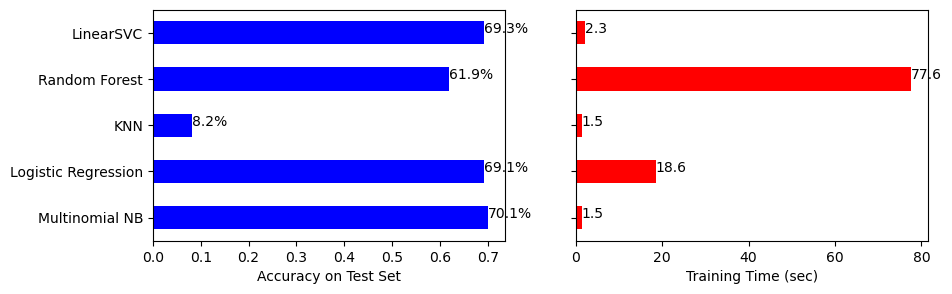

In [20]:
df = pd.DataFrame(evaluations).set_index('classifier')
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

df['accuracy'].plot.barh(ax=axes[0], color='blue')
axes[0].set_xlabel('Accuracy on Test Set')
axes[0].set_ylabel('')  # Removing y-label
for index, value in enumerate(df['accuracy']):
    axes[0].text(value, index, f'{value * 100:.1f}%')

df['training_time'].plot.barh(ax=axes[1], color='red')
axes[1].set_xlabel('Training Time (sec)')
for index, value in enumerate(df['training_time']):
    axes[1].text(value, index, f'{value:.1f}')

plt.savefig('figures/document_classification_benchmarking.pdf', bbox_inches='tight')

### 7. Find the Most Informative Features

In [21]:
def show_top_n_features(pipeline, categories, n=5):
    # Retrieve the array of feature names from the vectorizer
    feature_names = pipeline.named_steps['vect'].get_feature_names_out()
    
    # Retrieve the classifier from the pipeline
    clf = pipeline.named_steps['clf']
    
    for i, category in enumerate(categories):    
        # Get indices of top n features sorted by importance in descending order
        top_n = np.argsort(clf.feature_log_prob_[i])[-n:][::-1]
        
        # Fetch the feature names using the indices and join them into a formatted string
        print(f"{category}: {' '.join(feature_names[top_n])}")
        
show_top_n_features(model, categories)  # Using the trained MultinomialNB model

alt.atheism: god people don think atheism
comp.graphics: graphics image thanks files file
comp.os.ms-windows.misc: windows file dos files use
comp.sys.ibm.pc.hardware: drive scsi card bus controller
comp.sys.mac.hardware: mac apple drive problem thanks
comp.windows.x: window motif server widget thanks
misc.forsale: sale 00 offer shipping new
rec.autos: car cars like engine just
rec.motorcycles: bike dod bikes ride motorcycle
rec.sport.baseball: year team baseball game games
rec.sport.hockey: game team hockey play players
sci.crypt: key encryption clipper chip government
sci.electronics: use power circuit like does
sci.med: msg geb gordon pitt n3jxp
sci.space: space nasa orbit launch moon
soc.religion.christian: god jesus church christians people
talk.politics.guns: gun guns people weapons don
talk.politics.mideast: israel israeli jews armenian armenians
talk.politics.misc: people government don tax think
talk.religion.misc: god jesus christian people bible
